In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

import torch
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph, GATConv, global_mean_pool
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
%matplotlib widget

In [26]:
# Check for CUDA (NVIDIA) or MPS (Apple)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

NVIDIA GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Using device: cuda


In [27]:
# Load in the signal metadata
nubb_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_0nubb/1bar/5percent/reco_filtered/ATPC_0nubb_1bar_5percent_filtered.h5", "MC/hits")
nubb_meta["Type"] = "0nubb"
nubb_meta["subType"] = "0nubb"
display(nubb_meta)

# ----------------------------------------------------------------------------------------------------

# Load in the background
Bkg_meta = pd.DataFrame()
Tl_meta = pd.DataFrame()
Bi_meta = pd.DataFrame()

Tl_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Tl_ion/1bar/5percent/reco_filtered/ATPC_Tl_ion_1bar_5percent_filtered.h5", "MC/hits")
Tl_meta["subType"] = "Tl"
Bi_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Bi_ion/1bar/5percent/reco_filtered/ATPC_Bi_ion_1bar_5percent_filtered.h5", "MC/hits")
Bi_meta["subType"] = "Bi"
single_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_single/1bar/5percent/reco_filtered/ATPC_single_1bar_5percent_filtered.h5", "MC/hits")
single_meta["subType"] = "single"

Bkg_meta = pd.concat([Tl_meta, Bi_meta, single_meta])

Bkg_meta["Type"] = "Bkg"


display(Bkg_meta)

df = pd.concat([nubb_meta, Bkg_meta])
df = df.drop(columns=['x', 'y', 'z'])


# ----------------------------------------------------------------------------------------------------

# Load in the pickle files

def LoadPickle(f):
    # Load Bi data
    with open(f, 'rb') as pickle_file:
        Tracks = pickle.load(pickle_file)
        connections = pickle.load(pickle_file)
        connection_counts = pickle.load(pickle_file)
        
        return Tracks, connections, connection_counts

Tracks_0nubb,  connections_0nubb, connection_counts_0nubb   = LoadPickle("/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_0nubb/1bar/5percent/reco_filtered/ATPC_0nubb_1bar_5percent_pkl_filtered.h5")
Tracks_Bi,     connections_Bi, connection_counts_Bi         = LoadPickle("/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Bi_ion/1bar/5percent/reco_filtered/ATPC_Bi_ion_1bar_5percent_pkl_filtered.h5")
Tracks_Tl,     connections_Tl, connection_counts_Tl         = LoadPickle("/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Tl_ion/1bar/5percent/reco_filtered/ATPC_Tl_ion_1bar_5percent_pkl_filtered.h5")
Tracks_Single, connections_Single, connection_counts_Single = LoadPickle("/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_single/1bar/5percent/reco_filtered/ATPC_single_1bar_5percent_pkl_filtered.h5")

# Merge dictionaries
Tracks = {**Tracks_0nubb, **Tracks_Bi, **Tracks_Tl, **Tracks_Single}
connections = {**connections_0nubb,**connections_Bi, **connections_Tl,**connections_Single}
connection_counts = {**connection_counts_0nubb, **connection_counts_Bi, **connection_counts_Tl, **connection_counts_Single}


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,Type,subType
0,122,-1561.886724,-1493.918611,1512.290522,-1554.677368,-1489.785767,1508.124512,0.034792,0,0,1,0,0.000000,0.000000,2.125385,1.089913,0nubb,0nubb
1,122,-1544.894696,-1493.918611,1512.290522,-1543.320435,-1489.691711,1512.508423,0.094080,0,1,1,0,12.174049,138.048060,2.125385,1.089913,0nubb,0nubb
2,122,-1544.894696,-1476.926583,1512.290522,-1538.769165,-1480.243164,1513.530762,0.042178,0,2,1,0,22.711329,63.589735,2.046881,1.173988,0nubb,0nubb
3,122,-1527.902668,-1476.926583,1512.290522,-1531.169312,-1484.254028,1508.881348,0.003365,0,5,1,0,32.481788,94.490763,2.000895,1.322042,0nubb,0nubb
4,122,-1527.902668,-1493.918611,1512.290522,-1531.922852,-1491.922974,1513.565308,0.003935,0,4,1,0,41.499549,87.883052,2.065185,1.533477,0nubb,0nubb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,189786,2242.141629,-1737.116247,5360.944639,2248.882812,-1739.777954,5353.361328,0.065982,0,89,1,0,3140.165926,71.406394,3.658627,3.057292,0nubb,0nubb
102,189786,2269.775364,-1737.116247,5360.944639,2269.233398,-1727.197876,5367.596680,0.004590,0,95,1,0,3168.005645,54.132231,2.292515,1.749446,0nubb,0nubb
103,189786,2297.409099,-1709.482512,5333.310904,2288.433350,-1722.446777,5338.488281,0.025594,0,102,1,0,3203.198114,87.886567,1.692427,0.991755,0nubb,0nubb
104,189786,2297.409099,-1709.482512,5305.677169,2299.638550,-1718.641418,5300.070557,0.041808,0,104,1,0,3243.397105,17.191315,1.383993,0.598166,0nubb,0nubb


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,subType,Type
0,690067,1003.089627,-2084.759265,3774.037535,1005.368469,-2091.740967,3764.789551,0.027345,1,76,1,0,0.000000,0.000000,1.614405,0.986878,Tl,Bkg
1,690067,1003.089627,-2084.759265,3751.164581,1004.472310,-2087.679606,3757.281576,0.135265,1,73,1,0,8.582974,141.720230,1.708385,1.136662,Tl,Bkg
2,690067,1003.089627,-2061.886311,3774.037535,1003.787231,-2069.358643,3764.071533,0.011411,1,72,1,0,28.133692,81.762210,1.580232,1.042142,Tl,Bkg
3,690067,1003.089627,-2061.886311,3751.164581,1009.622681,-2055.565186,3748.831543,0.017685,1,77,1,0,49.501172,69.656040,1.494702,0.934464,Tl,Bkg
4,690067,1025.962582,-2061.886311,3751.164581,1023.269165,-2060.580811,3751.144043,0.005457,1,81,1,0,64.222948,94.520327,1.494702,0.934464,Tl,Bkg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,70151,-1219.433392,-2467.257314,3720.363916,-1226.355713,-2456.864014,3708.881348,0.001812,0,124,1,0,3563.305336,101.288501,1.624148,0.885389,single,Bkg
145,70151,-1242.541242,-2467.257314,3720.363916,-1240.709229,-2467.480225,3718.807373,0.162111,0,117,1,0,3583.732116,113.078870,1.771847,0.952384,single,Bkg
146,70151,-1265.649093,-2467.257314,3720.363916,-1254.262695,-2465.050537,3709.687256,0.059494,0,109,1,0,3600.248059,76.593874,1.727564,0.867392,single,Bkg
147,70151,-1589.158998,-2005.100306,2796.049900,-1597.664429,-2015.367432,2807.327148,0.006204,0,61,0,1,30.999426,177.517475,1.000000,0.000000,single,Bkg


In [28]:
# print(Tracks[122])

for t in Tracks[70151]:
    print(t)

print(connection_counts[70151])

{'id': 0, 'start': 92, 'end': 109, 'length': 3600.248, 'energy': 2.466097078897292, 'label': 'Primary', 'c': 'Teal', 'nodes': [92, 90, 89, 88, 86, 84, 79, 81, 82, 85, 80, 77, 75, 73, 72, 69, 65, 66, 62, 58, 64, 48, 42, 38, 34, 35, 37, 39, 43, 44, 51, 55, 60, 68, 63, 59, 56, 57, 54, 52, 46, 45, 47, 49, 50, 40, 33, 27, 23, 10, 4, 2, 1, 0, 3, 8, 16, 21, 26, 24, 18, 12, 17, 11, 13, 9, 6, 5, 7, 15, 32, 22, 28, 30, 20, 14, 19, 25, 29, 31, 36, 41, 53, 67, 71, 74, 76, 78, 83, 87, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 108, 118, 123, 135, 138, 142, 144, 146, 147, 148, 145, 143, 141, 140, 139, 137, 136, 125, 126, 122, 127, 112, 105, 103, 104, 106, 107, 111, 115, 114, 119, 129, 132, 120, 113, 110, 116, 133, 134, 128, 131, 130, 121, 124, 117, 109]}
{'id': 1, 'start': 50, 'end': 70, 'length': 56.603, 'energy': 0.009736493229866028, 'label': 'Delta0', 'c': 'DarkRed', 'nodes': [50, 61, 70]}
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3

In [ ]:
# About 5 mins to run
rows = []
for event_id, track_list in Tracks.items():
    for t in track_list:
        for node in t['nodes']:
            rows.append({
                'event_id': event_id,
                'id': node,
                'length': t['length'],
                'Etot': t['energy'],
                'label': t['label'],
            })
            
tracks_df = pd.DataFrame(rows)
df_merged = df.merge(
    tracks_df,
    how='inner',
    on=['event_id', 'id']
)

KeyboardInterrupt: 

In [30]:
display(df_merged[df_merged.event_id == 122])

,event_id,x_smear,y_smear,z_smear,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,Type,subType,length,Etot,label
0,122,-1561.886724,-1493.918611,1512.290522,0.034792,0,0,1,0,0.000000,0.000000,2.125385,1.089913,0nubb,0nubb,4276.852,2.438185,Primary
1,122,-1544.894696,-1493.918611,1512.290522,0.094080,0,1,1,0,12.174049,138.048060,2.125385,1.089913,0nubb,0nubb,4276.852,2.438185,Primary
2,122,-1544.894696,-1476.926583,1512.290522,0.042178,0,2,1,0,22.711329,63.589735,2.046881,1.173988,0nubb,0nubb,4276.852,2.438185,Primary
3,122,-1527.902668,-1476.926583,1512.290522,0.003365,0,5,1,0,32.481788,94.490763,2.000895,1.322042,0nubb,0nubb,4276.852,2.438185,Primary
4,122,-1527.902668,-1493.918611,1512.290522,0.003935,0,4,1,0,41.499549,87.883052,2.065185,1.533477,0nubb,0nubb,4276.852,2.438185,Primary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,122,-780.253421,-2275.551915,2090.019486,0.027776,0,110,1,0,4250.025912,99.123002,1.542183,0.960354,0nubb,0nubb,4276.852,2.438185,Primary
246,122,-780.253421,-2258.559886,2090.019486,0.056266,0,103,1,0,4267.155422,78.095902,1.492262,0.903441,0nubb,0nubb,4276.852,2.438185,Primary
247,122,-797.245449,-2258.559886,2090.019486,0.056522,0,100,1,0,4276.852418,40.860882,1.444962,0.881524,0nubb,0nubb,4276.852,2.438185,Primary
248,122,-899.197619,-2564.416396,1971.075287,0.022843,1,74,0,1,0.000000,0.000000,1.000000,0.000000,0nubb,0nubb,7.674,0.023983,Brem


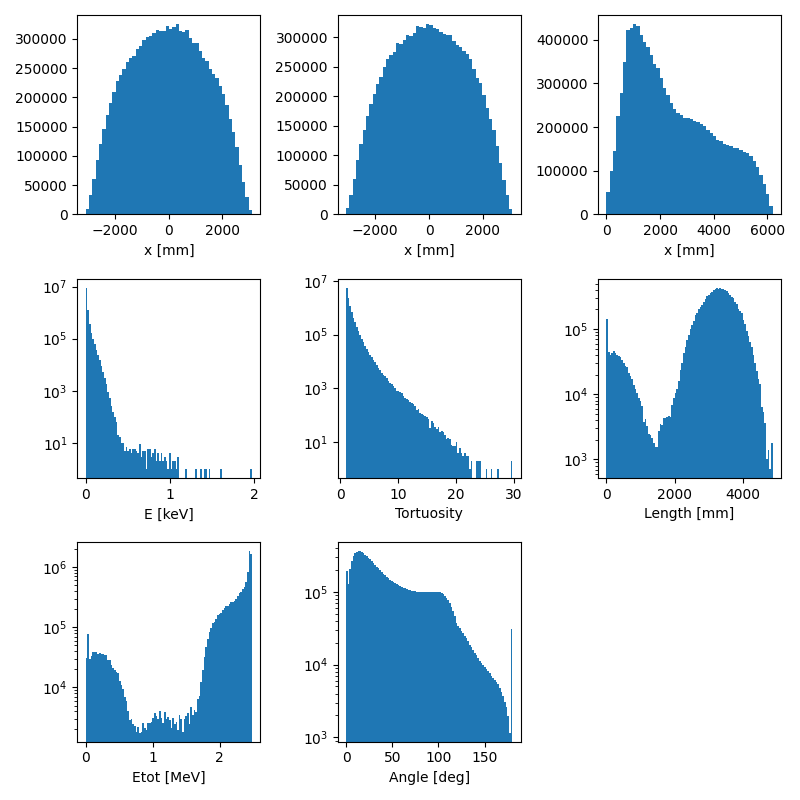

In [31]:
# Make some plots of the feature vectors before normalizing
fig  = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(331)
ax.hist(df_merged.x_smear, bins = 50);
ax.set_xlabel("x [mm]")

ax = fig.add_subplot(332)
ax.hist(df_merged.y_smear, bins = 50);
ax.set_xlabel("x [mm]")

ax = fig.add_subplot(333)
ax.hist(df_merged.z_smear, bins = 50);
ax.set_xlabel("x [mm]")

ax = fig.add_subplot(334)
ax.hist(df_merged.energy, bins=100);
ax.set_xlabel("E [keV]")
ax.semilogy()

ax = fig.add_subplot(335)
ax.hist(df_merged.Tortuosity, bins=100);
ax.set_xlabel("Tortuosity")
ax.semilogy()

ax = fig.add_subplot(336)
ax.hist(df_merged.length, bins=100);
ax.set_xlabel("Length [mm]")
ax.semilogy()

ax = fig.add_subplot(337)
ax.hist(df_merged.Etot, bins=100);
ax.set_xlabel("Etot [MeV]")
ax.semilogy()

ax = fig.add_subplot(338)
ax.hist(df_merged.angle, bins=100);
ax.set_xlabel("Angle [deg]")
ax.semilogy()

plt.tight_layout()


In [32]:
def MinMaxScale(df, label):
    # Min-Max scaling
    var_min = df[label].min()
    var_max = df[label].max()
    df[label] = (df[label] - var_min) / (var_max - var_min)
    return df

# Normalize the columns
xyz_mean = df_merged[["x_smear", "y_smear", "z_smear"]].mean()
xyz_std  = df_merged[["x_smear", "y_smear", "z_smear"]].std()
df_merged[["x_smear", "y_smear", "z_smear"]] = (df_merged[["x_smear", "y_smear", "z_smear"]] - xyz_mean) / xyz_std

df_merged = MinMaxScale(df_merged, "energy")
df_merged = MinMaxScale(df_merged, "Tortuosity")
df_merged = MinMaxScale(df_merged, "length")
df_merged = MinMaxScale(df_merged, "Etot")
df_merged = MinMaxScale(df_merged, "angle")

# features = ["event_id", "x_smear", "y_smear", "z_smear", "energy","Tortuosity","length","Etot" "Type", "subType"]
# df_merged = df_merged[features]

display(df_merged)

,event_id,x_smear,y_smear,z_smear,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,Type,subType,length,Etot,label
0,122,-1.103926,-1.060255,-0.647071,0.017469,0,0,1,0,0.000000,0.000000,3.917017e-02,1.089913,0nubb,0nubb,0.880156,0.982135,Primary
1,122,-1.091859,-1.060255,-0.647071,0.047521,0,1,1,0,12.174049,0.766934,3.917017e-02,1.089913,0nubb,0nubb,0.880156,0.982135,Primary
2,122,-1.091859,-1.048190,-0.647071,0.021213,0,2,1,0,22.711329,0.353276,3.643778e-02,1.173988,0nubb,0nubb,0.880156,0.982135,Primary
3,122,-1.079792,-1.048190,-0.647071,0.001540,0,5,1,0,32.481788,0.524949,3.483719e-02,1.322042,0nubb,0nubb,0.880156,0.982135,Primary
4,122,-1.079792,-1.060255,-0.647071,0.001829,0,4,1,0,41.499549,0.488239,3.707487e-02,1.533477,0nubb,0nubb,0.880156,0.982135,Primary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11116004,70151,-0.860732,-1.751373,0.788612,0.000753,0,124,1,0,3563.305336,0.562714,2.172413e-02,0.885389,Bkg,single,0.740914,0.993380,Primary
11116005,70151,-0.877142,-1.751373,0.788612,0.082004,0,117,1,0,3583.732116,0.628216,2.686492e-02,0.952384,Bkg,single,0.740914,0.993380,Primary
11116006,70151,-0.893552,-1.751373,0.788612,0.029990,0,109,1,0,3600.248059,0.425522,2.532360e-02,0.867392,Bkg,single,0.740914,0.993380,Primary
11116007,70151,-1.123293,-1.423219,0.187626,0.002979,0,61,0,1,30.999426,0.986208,3.864245e-18,0.000000,Bkg,single,0.011649,0.003789,Delta0


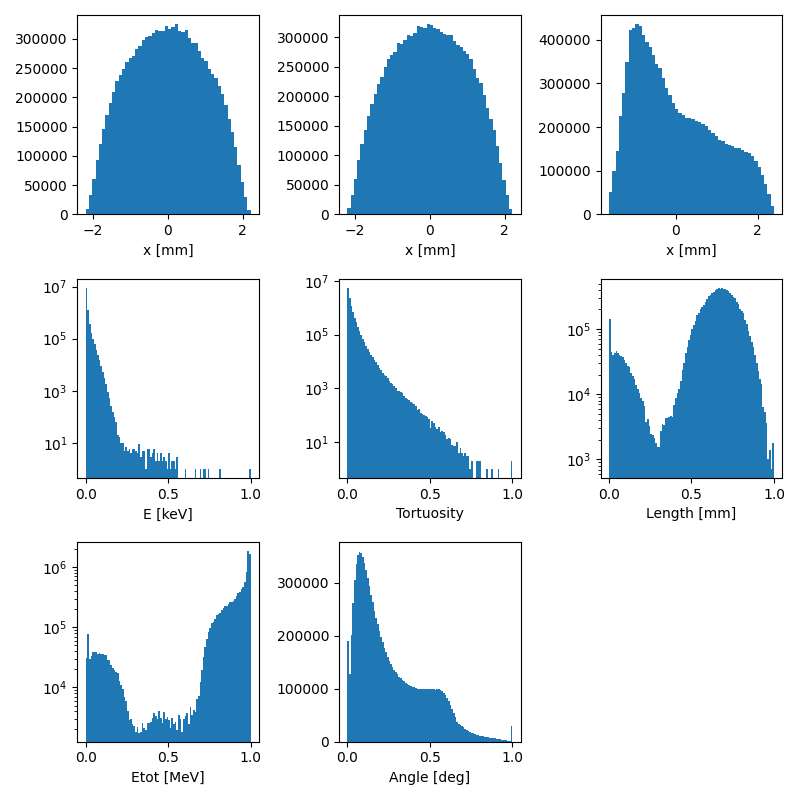

In [33]:
# Make some plots of the feature vectors after normalizing
fig  = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(331)
ax.hist(df_merged.x_smear, bins = 50);
ax.set_xlabel("x [mm]")

ax = fig.add_subplot(332)
ax.hist(df_merged.y_smear, bins = 50);
ax.set_xlabel("x [mm]")

ax = fig.add_subplot(333)
ax.hist(df_merged.z_smear, bins = 50);
ax.set_xlabel("x [mm]")

ax = fig.add_subplot(334)
ax.hist(df_merged.energy, bins=100);
ax.set_xlabel("E [keV]")
ax.semilogy()

ax = fig.add_subplot(335)
ax.hist(df_merged.Tortuosity, bins=100);
ax.set_xlabel("Tortuosity")
ax.semilogy()

ax = fig.add_subplot(336)
ax.hist(df_merged.length, bins=100);
ax.set_xlabel("Length [mm]")
ax.semilogy()

ax = fig.add_subplot(337)
ax.hist(df_merged.Etot, bins=100);
ax.set_xlabel("Etot [MeV]")
ax.semilogy()

ax = fig.add_subplot(338)
ax.hist(df_merged.angle, bins=100);
ax.set_xlabel("Angle [deg]")
# ax.semilogy()


plt.tight_layout()



In [34]:
# Convert the label category to a trainable parameter
df_merged['label_cat'] = (
    df_merged['label']
      .str.replace(r'^Delta\d+$', 'Delta', regex=True)
      .str.replace(r'^BremDelta\d+$', 'BremDelta', regex=True)
)
df_merged['label_cat'] = df_merged['label_cat'].astype('category')

df_merged['label_cat'] = df_merged['label_cat'].cat.set_categories(
    ['Primary', 'Delta', 'Brem', 'BremDelta'],
    ordered=False
)

# Integer encoding for training
df_merged['label_id'] = df_merged['label_cat'].cat.codes

display(df_merged)

,event_id,x_smear,y_smear,z_smear,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,Type,subType,length,Etot,label,label_cat,label_id
0,122,-1.103926,-1.060255,-0.647071,0.017469,0,0,1,0,0.000000,0.000000,3.917017e-02,1.089913,0nubb,0nubb,0.880156,0.982135,Primary,Primary,0
1,122,-1.091859,-1.060255,-0.647071,0.047521,0,1,1,0,12.174049,0.766934,3.917017e-02,1.089913,0nubb,0nubb,0.880156,0.982135,Primary,Primary,0
2,122,-1.091859,-1.048190,-0.647071,0.021213,0,2,1,0,22.711329,0.353276,3.643778e-02,1.173988,0nubb,0nubb,0.880156,0.982135,Primary,Primary,0
3,122,-1.079792,-1.048190,-0.647071,0.001540,0,5,1,0,32.481788,0.524949,3.483719e-02,1.322042,0nubb,0nubb,0.880156,0.982135,Primary,Primary,0
4,122,-1.079792,-1.060255,-0.647071,0.001829,0,4,1,0,41.499549,0.488239,3.707487e-02,1.533477,0nubb,0nubb,0.880156,0.982135,Primary,Primary,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11116004,70151,-0.860732,-1.751373,0.788612,0.000753,0,124,1,0,3563.305336,0.562714,2.172413e-02,0.885389,Bkg,single,0.740914,0.993380,Primary,Primary,0
11116005,70151,-0.877142,-1.751373,0.788612,0.082004,0,117,1,0,3583.732116,0.628216,2.686492e-02,0.952384,Bkg,single,0.740914,0.993380,Primary,Primary,0
11116006,70151,-0.893552,-1.751373,0.788612,0.029990,0,109,1,0,3600.248059,0.425522,2.532360e-02,0.867392,Bkg,single,0.740914,0.993380,Primary,Primary,0
11116007,70151,-1.123293,-1.423219,0.187626,0.002979,0,61,0,1,30.999426,0.986208,3.864245e-18,0.000000,Bkg,single,0.011649,0.003789,Delta0,Delta,1


In [35]:
# Split the dataset based on the event ids not the rows

# Event-level labels (one row per event)
event_labels = (df_merged.groupby("event_id")["Type"].first().eq("0nubb").astype(int))
print(event_labels.value_counts().rename({1: "0nubb", 0: "Bkg"}))

event_ids = event_labels.index.values
event_y   = event_labels.values

ev_tmp, ev_test, y_tmp, y_test   = train_test_split(event_ids, event_y, test_size=0.10, stratify=event_y, random_state=42)
ev_train, ev_val, y_train, y_val = train_test_split(ev_tmp,y_tmp, test_size=2/9, stratify=y_tmp, random_state=42)

train_df = df_merged[df_merged["event_id"].isin(ev_train)].copy()
val_df   = df_merged[df_merged["event_id"].isin(ev_val)].copy()
test_df  = df_merged[df_merged["event_id"].isin(ev_test)].copy()

assert set(train_df.event_id).isdisjoint(val_df.event_id)
assert set(train_df.event_id).isdisjoint(test_df.event_id)

label_map = {"0nubb": 1, "Bkg": 0}
train_df["label"] = (train_df["Type"] == "0nubb").astype(int)
val_df["label"]   = (val_df["Type"] == "0nubb").astype(int)
test_df["label"]  = (test_df["Type"] == "0nubb").astype(int)


Type
0nubb    35050
Bkg      33212
Name: count, dtype: int64


In [97]:
# Data Loaders
# Function to convert the df to a graph

# Desired node features:
# Energy of node
# X,Y,Z of node -- possibly remove these...
# Tortuosity of node
# Energy of track which node belongs to
# Length of track which node belongs to
# Class of track e.g. Primary, Delta, Brem, BremDelta

# Edge features
# Displacement of node
# Angle of node to next node

# Connections
# Use connections provided by the tracking algorithm. 

def event_to_radius_graph(event_df, r=15.0, max_neighbors=32):
    
    pos = torch.tensor(
        event_df[["x_smear", "y_smear", "z_smear"]].values,
        dtype=torch.float32
    ) # N rows of [x,y,z]

    x = torch.tensor(event_df[["x_smear", "y_smear", "z_smear", "energy"]].values, dtype=torch.float32) # (N,4): N rows of [x,y,z,E]

    # Computes graph edges to all points within a given distance.
    # Outputs in Coordinate List (COO) format
    edge_index = radius_graph(pos, r=r, max_num_neighbors=max_neighbors, loop=False) # (2,E), E = number of edges containing pairs of [source_node_index, target_node_index].

    # Source and Destination -- indexes to the pos and x vectors
    src, dst = edge_index

    delta = pos[dst] - pos[src]
    dist = torch.norm(delta, dim=1, keepdim=True) # calc distance between nodes

    edge_attr = torch.cat([delta, dist], dim=1)  # (E, 4) [Δx,Δy,Δz,distance]

    y = torch.tensor([event_df["label"].iloc[0]],dtype=torch.long)

    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y
    )

def event_to_track_graph(event_df, Track):
    pos = torch.tensor(
        event_df[["x_smear", "y_smear", "z_smear"]].values,
        dtype=torch.float32
    ) # N rows of [x,y,z]
    
    x = torch.tensor(event_df[["x_smear", "y_smear", "z_smear", "energy", "Tortuosity","length","Etot", "label_id"]].values, dtype=torch.float32) # (N,8): N rows of these features
    event_id = torch.tensor(event_df.event_id.unique())

    # Build the track
    edge_index, edge_attr = build_track_edges_with_attr(Track, pos)
    
    y = torch.tensor([event_df["label"].iloc[0]],dtype=torch.long)
    
    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        event_id=event_id
    )

def build_track_edges_with_attr(tracks, pos):
    src = []
    dst = []
    edge_attr = []
    prev_dir = None  # for angle computation

    for t in tracks:
        nodes = t['nodes']
        for i in range(len(nodes) - 1):
            u = nodes[i]
            v = nodes[i + 1]

            # displacement vector
            d = pos[v] - pos[u]      # (dx, dy, dz)
            d_norm = d / 10.              # Divide by 10 to get a scale closer to ~1
            dist = torch.norm(d)     # |d|

            # direction / angle
            direction = d / (dist + 1e-8)
            
            # angle wrt previous segment
            if prev_dir is None:
                theta_norm = torch.tensor(0.0)
            else:
                cos_theta = torch.dot(prev_dir, direction)
                cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
                theta = torch.acos(cos_theta)
                theta_norm = theta / math.pi # normalize angle
            
            prev_dir = direction

            src.append(u)
            dst.append(v)

            edge_attr.append(
                torch.cat([d_norm, theta_norm.unsqueeze(0)])
            )

    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_attr = torch.stack(edge_attr)

    return edge_index, edge_attr



def build_graph_dataset(df):
    graphs = []
    for ev_id in df.event_id.unique():
        # graphs.append(event_to_radius_graph(ev_df, r=0.3)) # Radius connections
        graphs.append(event_to_track_graph(df[df.event_id == ev_id], Tracks[ev_id])) # Track connections
    return graphs

train_graphs = build_graph_dataset(train_df)
val_graphs   = build_graph_dataset(val_df)
test_graphs  = build_graph_dataset(test_df)

train_loader = DataLoader(train_graphs,batch_size=8, shuffle=True,  num_workers=10, pin_memory=True)
val_loader   = DataLoader(val_graphs,  batch_size=16,shuffle=False, num_workers=10, pin_memory=True)
test_loader  = DataLoader(test_graphs, batch_size=16,shuffle=False, num_workers=10, pin_memory=True)

In [98]:
# Define the GNN
class GATNet(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, heads=4):
        super().__init__()

        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads, concat=False) # concat False keeps hidden_channels fixed
        self.conv2 = GATConv(hidden_channels,   hidden_channels, heads=heads, concat=False)
        self.conv3 = GATConv(hidden_channels,   hidden_channels, heads=1,     concat=False)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x
    
class GATNetEdge(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, edge_dim, heads=4):
        super().__init__()

        self.conv1 = GATConv( num_node_features, hidden_channels, heads=heads, concat=False, edge_dim=edge_dim)
        self.conv2 = GATConv( hidden_channels,   hidden_channels, heads=heads, concat=False, edge_dim=edge_dim)
        self.conv3 = GATConv( hidden_channels,   hidden_channels, heads=1,     concat=False, edge_dim=edge_dim)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = getattr(data, 'edge_attr', None)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [132]:
def accuracy_from_logits(logits, y_true):
    preds = logits.argmax(dim=1)
    return (preds == y_true).float().mean().item()

# model = GATNet(hidden_channels=64, num_classes=2, num_node_features = 8).to(device)
model = GATNetEdge(hidden_channels=64, num_classes=2, edge_dim=4, num_node_features = 8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([1.0, 1.0])  # [background, signal]
).to(device)

train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(5):

    # -------- training --------
    # Put the model in training mode, gradients will be computed
    model.train() 
    train_loss = 0.0 # Sum the loss over all batches, then average it

    # Loop over training batches
    for data in train_loader:
        
        data = data.to(device) # Move the whole graph batch to GPU
        
        # print("x:", data.x.shape)
        # print("edge_index:", data.edge_index.shape)
        # print("edge_attr:", data.edge_attr.shape)
        
        optimizer.zero_grad()            # Clear old features
        logits = model(data)             # Data flows through the network, the output is called logits (raw scores not probabilities)
        loss = criterion(logits, data.y) # Compares the predictions (logits) with the true labels (yb)
        loss.backward()                  # Computes the gradients of the loss (stored in param.grad for every model param)
        optimizer.step()                 # Uses the gradients to update the weights. Depends on the optimizer e.g. SGD, Adam etc -- this is the learning step

        train_loss += loss.item() * data.num_graphs # Accumulates the total loss. loss.item() returns the loss for this batch. So multiply by batch size data.num_graphs 

    train_loss /= len(train_loader.dataset) # Average the training loss over the total dataset
    train_loss_hist.append(train_loss)

    # -------- validation --------
    model.eval() # Disables dropout, freezes batchnorm statistics, ensures deterministic behaviour
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad(): # Disables gradient tracking (saves memory, speeds up evalulation, prevents accidental backpropagation)
        for data in val_loader:
            data = data.to(device) # Move the whole graph batch to GPU
            
            logits = model(data)
            loss = criterion(logits, data.y)

            val_loss += loss.item() * data.num_graphs
            val_acc += accuracy_from_logits(logits, data.y) * data.num_graphs # Converts logits -> predicted class, compares with y

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f} | "
        f"Val acc: {val_acc:.3f}"
    )

model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for data in test_loader:
        
        data = data.to(device) # Move the whole graph batch to GPU
        
        logits = model(data)
        loss = criterion(logits, data.y)

        test_loss += loss.item() * data.num_graphs
        test_acc  += accuracy_from_logits(logits, data.y) * data.num_graphs

test_loss /= len(test_loader.dataset)
test_acc  /= len(test_loader.dataset)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")

Epoch 001 | Train loss: 0.5902 | Val loss: 0.5836 | Val acc: 0.707
Epoch 002 | Train loss: 0.5773 | Val loss: 0.5743 | Val acc: 0.715
Epoch 003 | Train loss: 0.5699 | Val loss: 0.5700 | Val acc: 0.715
Epoch 004 | Train loss: 0.5647 | Val loss: 0.5624 | Val acc: 0.730
Epoch 005 | Train loss: 0.5553 | Val loss: 0.5479 | Val acc: 0.730
Test loss: 0.5585 | Test acc: 0.719


In [133]:
def compute_roc(model, loader, device):
    model.eval()
    y_true, y_score, p_signal_bkg, p_signal_sig, event_ids = [], [], [], [], []

    with torch.no_grad():
        # Loops over in batches specified in dataloader, returns array of length of the batch size. 
        for data in loader:
            data = data.to(device)
            logits = model(data)
            probs = torch.softmax(logits, dim=1) # List of length batch size, 2 rows, [p_bkg, p_sig]
            
            p_signal = probs[:, 1].cpu() # Get the signal column probs
            y        = data.y.cpu()      # Get the y labels
            
            y_score.append(p_signal)
            y_true.append(y)
            event_ids.append(data.event_id.cpu())
            
            # Append scores depending on true classification
            p_signal_bkg.append(p_signal[y.numpy() == 0])
            p_signal_sig.append(p_signal[y.numpy() == 1])

    y_true  = torch.cat(y_true).numpy()
    y_score = torch.cat(y_score).numpy()
    event_ids = torch.cat(event_ids).numpy()
    
    p_signal_bkg = np.concatenate(p_signal_bkg)
    p_signal_sig = np.concatenate(p_signal_sig)
    
    df_scores = pd.DataFrame({"event_id":event_ids, "y_score":y_score, "y_true":y_true})

    fpr, tpr, _ = roc_curve(y_true, y_score)
    
    return fpr, tpr, auc(fpr, tpr), df_scores

fpr_tr,   tpr_tr, auc_tr,   df_scores_tr  = compute_roc(model, train_loader, device)
fpr_va,   tpr_va, auc_va,   df_scores_va = compute_roc(model, val_loader,   device)
fpr_tst, tpr_tst, auc_tst,  df_scores_tst = compute_roc(model, test_loader,  device)
df_scores_all = pd.concat([df_scores_tr, df_scores_va, df_scores_tst])
display(df_scores_all)

,event_id,y_score,y_true
0,5286653,0.695994,0
1,1825740235,0.038898,0
2,1912,0.148893,1
3,158968,0.248536,1
4,183528,0.781233,1
...,...,...,...
6822,6932190,0.293514,0
6823,6946249,0.670670,0
6824,6946500,0.276871,0
6825,6953238,0.065882,0


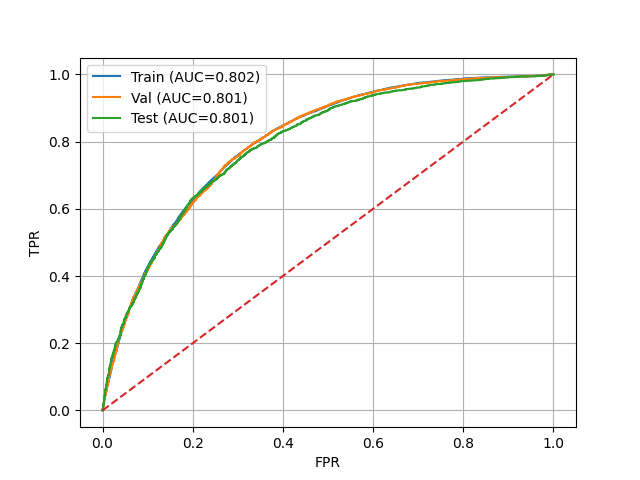

In [134]:
plt.figure()
plt.plot(fpr_tr, tpr_tr, label=f"Train (AUC={auc_tr:.3f})")
plt.plot(fpr_va, tpr_va, label=f"Val (AUC={auc_va:.3f})")
plt.plot(fpr_tst, tpr_tst, label=f"Test (AUC={auc_va:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()


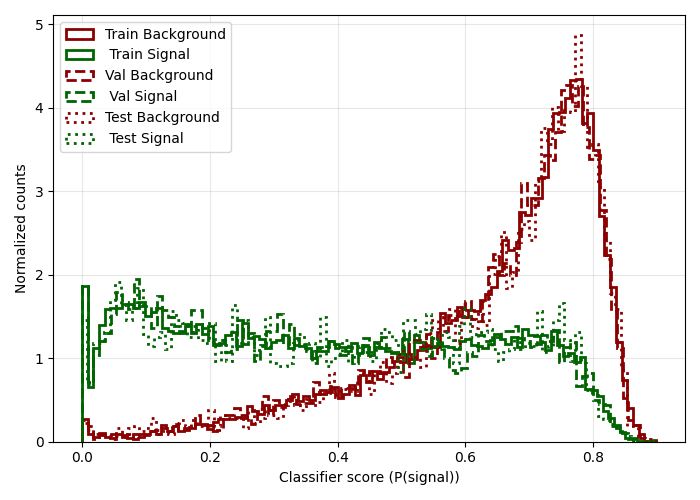

0.24659761531976393 0.3109272467902996


In [140]:
plt.figure(figsize=(7,5))

bins = 100


plt.hist(df_scores_tr[df_scores_tr.y_true == 1].y_score,bins=bins,density=True,histtype='step',linewidth=2,label='Train Background', linestyle = "-", color = "darkred")
plt.hist(df_scores_tr[df_scores_tr.y_true == 0].y_score,bins=bins,density=True,histtype='step',linewidth=2,label=' Train Signal', linestyle = "-", color = "darkgreen")

plt.hist(df_scores_va[df_scores_va.y_true == 1].y_score,bins=bins,density=True,histtype='step',linewidth=2,label='Val Background', linestyle = "--", color = "darkred")
plt.hist(df_scores_va[df_scores_va.y_true == 0].y_score,bins=bins,density=True,histtype='step',linewidth=2,label=' Val Signal', linestyle = "--", color = "darkgreen")

plt.hist(df_scores_tst[df_scores_tst.y_true == 1].y_score,bins=bins,density=True,histtype='step',linewidth=2,label='Test Background', linestyle = ":", color = "darkred")
plt.hist(df_scores_tst[df_scores_tst.y_true == 0].y_score,bins=bins,density=True,histtype='step',linewidth=2,label=' Test Signal', linestyle = ":", color = "darkgreen")


plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

# plt.semilogy()
plt.tight_layout()
plt.show()

cut = 0.6
signal_eff = len(df_scores_all[ (df_scores_all.y_true == 0) & (df_scores_all.y_score > cut)])/len(df_scores_all[ (df_scores_all.y_true == 0)])
bkg_rej = 1 - len(df_scores_all[ (df_scores_all.y_true == 1) & (df_scores_all.y_score > cut)])/len(df_scores_all[ (df_scores_all.y_true == 1)])
print(signal_eff, bkg_rej)

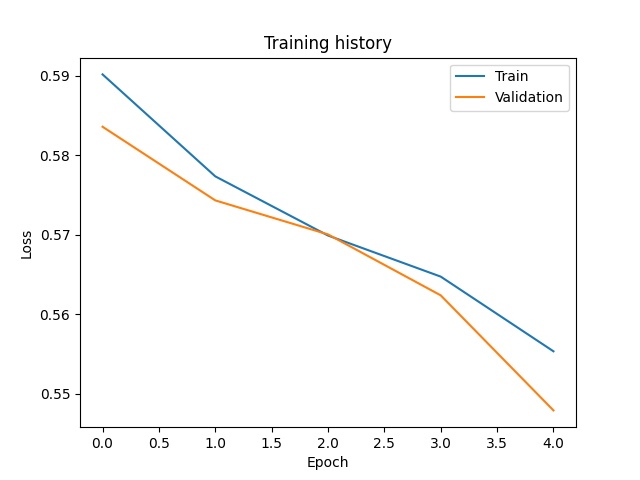

In [141]:
plt.figure()
plt.plot(train_loss_hist, label='Train')
plt.plot(val_loss_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training history')
plt.show()



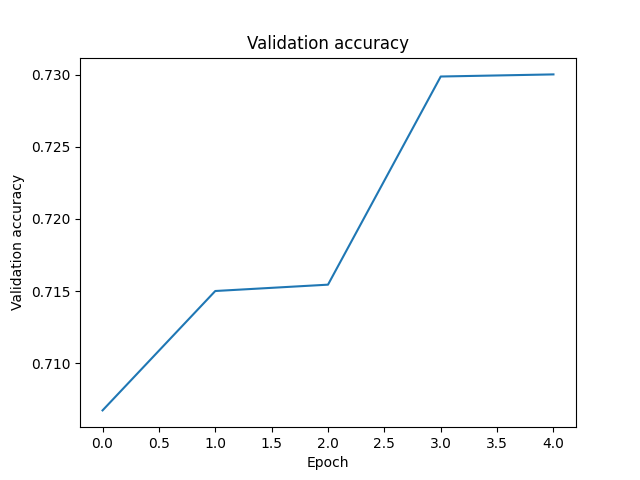

In [142]:
plt.figure()
plt.plot(val_acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy')
plt.show()

In [143]:
# Merge categories column to df score so we can plot the performance vs background type
# display(df_merged[["event_id", "subType"]])
df_scores_merged = df_merged.drop_duplicates(subset=['event_id'])
df_scores_merged = df_scores_merged[["event_id", "subType"]]

df_scores_merged = pd.merge(df_scores_merged, df_scores_all, on="event_id")
display(df_scores_merged)


,event_id,subType,y_score,y_true
0,122,0nubb,0.384207,1
1,123,0nubb,0.221956,1
2,124,0nubb,0.488435,1
3,126,0nubb,0.750925,1
4,127,0nubb,0.797496,1
...,...,...,...,...
68257,69853,single,0.525390,0
68258,70027,single,0.774963,0
68259,70046,single,0.453363,0
68260,70096,single,0.099907,0


Signal Eff: 0.6890727532097004
Tl ERej: 0.8826755565114528 4.057832248180774
Bi ERej: 0.7535630014157622 8.523373052245645
single ERej: 0.6630124643339841 2.9674688057040997


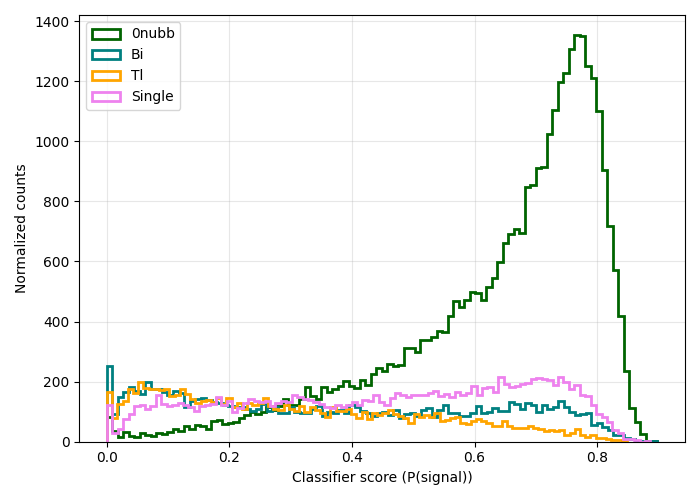

In [145]:
def CalcEfficiency(df, label, cut):
    num = len(df[ (df.subType == label) & (df.y_score > cut)])
    den = len(df[ (df.subType == label)])
    return num/den

print("Signal Eff:",    CalcEfficiency(df_scores_merged, "0nubb",  cut))
print("Tl ERej:",     1-CalcEfficiency(df_scores_merged, "Tl",     cut), 1/CalcEfficiency(df_scores_merged, "Bi",     cut))
print("Bi ERej:",     1-CalcEfficiency(df_scores_merged, "Bi",     cut), 1/CalcEfficiency(df_scores_merged, "Tl",     cut))
print("single ERej:", 1-CalcEfficiency(df_scores_merged, "single", cut), 1/CalcEfficiency(df_scores_merged, "single", cut))

plt.figure(figsize=(7,5))

bins = 100

plt.hist(df_scores_merged[ (df_scores_merged.subType == "0nubb")].y_score,bins=bins,density=False,histtype='step',linewidth=2,label='0nubb', color = "darkgreen");
plt.hist(df_scores_merged[ (df_scores_merged.subType == "Bi")].y_score,bins=bins,density=False,histtype='step',linewidth=2,label='Bi', color = "Teal");
plt.hist(df_scores_merged[ (df_scores_merged.subType == "Tl")].y_score,bins=bins,density=False,histtype='step',linewidth=2,label='Tl', color = "Orange");
plt.hist(df_scores_merged[ (df_scores_merged.subType == "single")].y_score,bins=bins,density=False,histtype='step',linewidth=2,label='Single', color = "violet");


plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

# plt.semilogy()
plt.tight_layout()
plt.show()

